In [15]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

N_STATES = 1000
trueStateValues = np.arange(-1001, 1003, 2) / 1001.0

# all states
states = np.arange(1, N_STATES + 1)

# start from a central state
START_STATE = 500

# terminal states
END_STATES = [0, N_STATES + 1]

# possible actions
ACTION_LEFT = -1
ACTION_RIGHT = 1
ACTIONS = [ACTION_LEFT, ACTION_RIGHT]

# maximum stride for an action
STEP_RANGE = 100

# DP 
while True:
    oldTrueStateValues = np.copy(trueStateValues)
    for state in states:
        trueStateValues[state] = 0
        for action in ACTIONS:
            for step in range(1, STEP_RANGE + 1):
                step *= action
                newState = state + step
                newState = max(min(newState, N_STATES + 1), 0)
                trueStateValues[state] += 1.0 / (2 * STEP_RANGE) * trueStateValues[newState]
    error = np.sum(np.abs(oldTrueStateValues - trueStateValues))
    print(error)
    if error < 1e-2:
        break
# correcting end state values
trueStateValues[0] = trueStateValues[-1] = 0

# take an @action at @state, return new state and reward for this transition
def takeAction(state, action):
    step = np.random.randint(1, STEP_RANGE + 1)
    step *= action
    state += step
    state = max(min(state, N_STATES + 1), 0)
    if state == 0:
        reward = -1
    elif state == N_STATES + 1:
        reward = 1
    else:
        reward = 0
    return state, reward

def getAction():
    if np.random.binomial(1, 0.5) == 1:
        return 1
    return -1

class ValueFunction:
    def __init__(self, numOfGroups):
        self.numOfGroups = numOfGroups
        self.groupSize = N_STATES // numOfGroups
        self.params = np.zeros(numOfGroups)
    def value(self, state):
        if state in END_STATES:
            return 0
        groupIndex = (state - 1) // self.groupSize
        return self.params[groupIndex]
    def update(self, delta, state):
        groupIndex = (state - 1) // self.groupSize
        self.params[groupIndex] += delta

# semi-gradient n-step TD algorithm
# @valueFunction: an instance of class ValueFunction
# @n: # of steps
# @alpha: step size
def semiGradientTemporalDifference(valueFunction, n, alpha):
    currentState = START_STATE
    states = [currentState]
    rewards = [0]
    time = 0
    T = float('inf')
    while True:
        time += 1
        if time < T:
            action = getAction()
            newState, reward = takeAction(currentState, action)
            states.append(newState)
            rewards.append(reward)
            if newState in END_STATES:
                T = time
        updateTime = time - n
        if updateTime >= 0:
            returns = 0.0
            # calculate corresponding rewards
            for t in range(updateTime + 1, min(T, updateTime + n) + 1):
                returns += rewards[t]
            # add state value to the return
            if updateTime + n <= T:
                returns += valueFunction.value(states[updateTime + n])
            stateToUpdate = states[updateTime]
            # update the value function
            if not stateToUpdate in END_STATES:
                delta = alpha * (returns - valueFunction.value(stateToUpdate))
                valueFunction.update(delta, stateToUpdate)
        if updateTime == T - 1:
            break
        currentState = newState

# semi-gradient TD on 1000-state random walk
def figure9_2Left():
    nEpisodes = int(1e5)
    alpha = 2e-4
    valueFunction = ValueFunction(10)
    for episode in range(0, nEpisodes):
        #print('episode:', episode)
        semiGradientTemporalDifference(valueFunction, 1, alpha)

    stateValues = [valueFunction.value(i) for i in states]
    plt.figure(2)
    plt.plot(states, stateValues, label='Approximate TD value')
    plt.plot(states, trueStateValues[1: -1], label='True value')
    plt.xlabel('State')
    plt.ylabel('Value')
    plt.legend()

# different alphas and steps for semi-gradient TD
def figure9_2Right():
    # truncate value for better display
    truncateValue = 0.55

    # all possible steps
    steps = np.power(2, np.arange(0, 10))

    # all possible alphas
    alphas = np.arange(0, 1.1, 0.1)

    # each run has 10 episodes
    episodes = 10

    # perform 100 independent runs
    runs = 100

    # track the errors for each (step, alpha) combination
    errors = np.zeros((len(steps), len(alphas)))
    for run in range(0, runs):
        for stepInd, step in zip(range(len(steps)), steps):
            for alphaInd, alpha in zip(range(len(alphas)), alphas):
                #print('run:', run, 'step:', step, 'alpha:', alpha)
                # we have 20 aggregations in this example
                valueFunction = ValueFunction(20)
                for ep in range(0, episodes):
                    semiGradientTemporalDifference(valueFunction, step, alpha)
                    # calculate the RMS error
                    currentStateValues = np.asarray([valueFunction.value(i) for i in states])
                    errors[stepInd, alphaInd] += np.sqrt(np.sum(np.power(currentStateValues - trueStateValues[1: -1], 2)) / N_STATES)
    # take average
    errors /= episodes * runs
    # truncate the error
    errors[errors > truncateValue] = truncateValue
    plt.figure(3)
    for i in range(0, len(steps)):
        plt.plot(alphas, errors[i, :], label='n = ' + str(steps[i]))
    plt.xlabel('alpha')
    plt.ylabel('RMS error')
    plt.legend()

# Figure 9.2, it will take quite a while
def figure9_2():
    figure9_2Left()
    figure9_2Right()

5.21985625061
3.14750476413
2.42001653274
2.0309643686
1.76577460483
1.55975616071
1.38758848476
1.23824466538
1.10644734134
0.989287455122
0.884843397596
0.791615561618
0.708337797554
0.633894504141
0.567296333649
0.507672253653
0.454261281028
0.406406739956
0.363533447723
0.325140660034
0.290785478357
0.260072448728
0.232646333335
0.20818499897
0.186396488514
0.167015025874
0.14980032428
0.134532816512
0.121014797938
0.109066686265
0.0985270181556
0.0892501066648
0.0811047384286
0.0739731222597
0.0677496685896
0.062339680947
0.0576581451771
0.0536289301263
0.0501834224699
0.0472599434093
0.0448024672685
0.042759061373
0.0410820240198
0.0397240160159
0.0386347419471
0.0377465023309
0.0369300449012
0.0361061477072
0.0352775563306
0.0344475931823
0.0336191392044
0.0327946821717
0.0319763603873
0.0311660020832
0.0303651608446
0.0295751473858
0.0287970579964
0.0280317999592
0.0272801142272
0.026542595631
0.0258197108576
0.0251118144342
0.0244191629199
0.023741927497
0.0230802051304
0.0224

In [16]:
figure9_2Left()

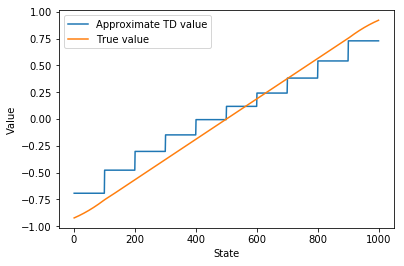

In [17]:
plt.show()

In [18]:
figure9_2Right()

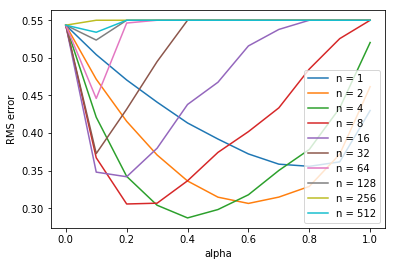

In [19]:
plt.show()